In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from pyspark.sql import SparkSession

In [16]:
sc=SparkSession.builder.getOrCreate()

DF_True=sc.read.csv('True.csv',header=True,inferSchema=True)
DF_Fake=sc.read.csv('Fake.csv',header=True,inferSchema=True)

DF_True.createOrReplaceTempView('DF_True')
DF_Fake.createOrReplaceTempView('DF_Fake')

In [11]:
print('DF_True Info:\n dimensions: (%d, %d)\n Columns: %s' % (DF_True.count(),len(DF_True.columns),DF_True.columns))
print('DF_Fake Info:\n dimensions: (%d, %d)\n Columns: %s' % (DF_Fake.count(),len(DF_Fake.columns),DF_Fake.columns))

DF_True Info:
 dimensions: (21417, 4)
 Columns: ['title', 'text', 'subject', 'date']
DF_Fake Info:
 dimensions: (23489, 4)
 Columns: ['title', 'text', 'subject', 'date']


In [23]:
# heads, excluding text
print('DF_True head\n\n',
DF_True[['title','subject','date']].head(5),
'\n\nDF_Fake head \n\n',
DF_Fake[['title','subject','date']].head(5))

DF_True head

 [Row(title='As U.S. budget fight looms, Republicans flip their fiscal script', subject='politicsNews', date='December 31, 2017 '), Row(title='U.S. military to accept transgender recruits on Monday: Pentagon', subject='politicsNews', date='December 29, 2017 '), Row(title="Senior U.S. Republican senator: 'Let Mr. Mueller do his job'", subject='politicsNews', date='December 31, 2017 '), Row(title='FBI Russia probe helped by Australian diplomat tip-off: NYT', subject='politicsNews', date='December 30, 2017 '), Row(title="Trump wants Postal Service to charge 'much more' for Amazon shipments", subject='politicsNews', date='December 29, 2017 ')] 

DF_Fake head 

 [Row(title=' Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing', subject='News', date='December 31, 2017'), Row(title=' Drunk Bragging Trump Staffer Started Russian Collusion Investigation', subject='News', date='December 31, 2017'), Row(title=' Sheriff David Clarke Becomes An Internet Joke

In [42]:
# subject distribution, order by count descending?
print('DF_True subject count')
sc.sql('select subject, count(subject) from DF_True group by subject order by count(subject) desc').show()

DF_True subject count
+--------------------+--------------+
|             subject|count(subject)|
+--------------------+--------------+
|        politicsNews|         11209|
|           worldnews|         10115|
|"" Trump Jr. resp...|             2|
|"" said Phil Orlando|             1|
| Associates Up 83...|             1|
|           Australia|             1|
|"" according to t...|             1|
| "" said Tom Vilsack|             1|
|"" Petrocelli tol...|             1|
| said Joseph Cassidy|             1|
| U.S. beef hits C...|             1|
|      if implemented|             1|
|       Linda McMahon|             1|
|"" he said during...|             1|
| Pruitt decided n...|             1|
| one of the lobby...|             1|
|       nor will help|             1|
| Poland: bit.ly/2...|             1|
|"" Intel Chief Ex...|             1|
|"" Mattis said in...|             1|
+--------------------+--------------+
only showing top 20 rows



In [41]:
print('DF_Fake subject count')
sc.sql('select subject, count(subject) from DF_Fake group by subject order by count(subject) desc').show()

DF_Fake subject count
+--------------------+--------------+
|             subject|count(subject)|
+--------------------+--------------+
|                News|          8501|
|            politics|          6525|
|           left-news|          4216|
|     Government News|          1543|
|             US_News|           767|
|         Middle-east|           762|
|     fjs);}(document|           124|
|               2017"|            26|
|               2016"|            18|
| 2016Featured ima...|             8|
| i'm sure it wasn...|             8|
|                   s|             7|
|              2017 "|             7|
| 2017Ranking memb...|             7|
| and?"" he says. ...|             6|
| make it into art...|             5|
| fry em like baco...|             5|
|         in his mind|             4|
|      2017So all day|             4|
| 2017.@Delta empl...|             4|
+--------------------+--------------+
only showing top 20 rows



This could be good cause to simply ignore the subject column in our model later.

Any NULL values?

In [22]:
sc.sql('select * from DF_True where title is null or text is null or subject is null').show()
sc.sql('select * from DF_Fake where title is null or text is null or subject is null').show()

+-----+----+-------+----+
|title|text|subject|date|
+-----+----+-------+----+
+-----+----+-------+----+

+--------------------+----+-------+----+
|               title|text|subject|date|
+--------------------+----+-------+----+
|                   "|null|   null|null|
|Ex-GOP Congressma...|null|   null|null|
|                   "|null|   null|null|
|WATCH: Democratic...|null|   null|null|
|                   "|null|   null|null|
|Trump Gets STOMPE...|null|   null|null|
|                   "|null|   null|null|
|Donald Trump Gets...|null|   null|null|
+--------------------+----+-------+----+



This could actually cause Tokenizer problems in a pipeline, but can be easily solved with an nafill command.  Also, note some of the titles simply have a single quotation mark.  Are there other titles that are very short?

In [23]:
sc.sql('select title from DF_True where length(title)<=5').show()
sc.sql('select title from DF_Fake where length(title)<=5').show()

+-----+
|title|
+-----+
+-----+

+-----+
|title|
+-----+
|    "|
|    "|
|    "|
|    "|
+-----+



So we'll probably just remove these 4 records from the dataset since the rest of their rows are null as seen above.

We could also look at word counts from the entirety of the text bodies.  In particular, we will look at word density.  We'll do this in Pandas since the files aren't too big.

In [2]:
DF_True=pd.read_csv('True.csv')
DF_Fake=pd.read_csv('Fake.csv')

In [3]:
# this cell may take a few minutes to run
s=''
# record number of total articles
DF_True_size=DF_True.shape[0]
# collect all words from all text bodies
for article in range(DF_True_size):
    s+=' '+str(DF_True['text'].iloc[article])
# group them into a frequency dictionary
d_True={}
tokens=s.split()
del s
for word in tokens:
    try:
        d_True[word]+=1
    except KeyError:
        d_True[word]=1
del tokens
# replace word count with word density by dividing in place by total articles
for key in d_True.keys():
    d_True[key]/=DF_True_size
# make list of the word densities
D_True=list(d_True.items())
# flip them so the density is first
D_True=[tuple(reversed(t)) for t in D_True]
# sort list by descending number
D_True.sort(reverse=True)

And we do the same for DF_Fake:

In [4]:
# this cell may take a few minutes to run
s=''
# record number of total articles
DF_Fake_size=DF_Fake.shape[0]
# collect all words from all text bodies
for article in range(DF_Fake_size):
    s+=' '+str(DF_Fake['text'].iloc[article])
# group them into a frequency dictionary
d_Fake={}
tokens=s.split()
del s
for word in tokens:
    try:
        d_Fake[word]+=1
    except KeyError:
        d_Fake[word]=1
del tokens
# replace word count with word density by dividing in place by total articles
for key in d_Fake.keys():
    d_Fake[key]/=DF_Fake_size
# make list of the word densities
D_Fake=list(d_Fake.items())
# flip them so the density is first
D_Fake=[tuple(reversed(t)) for t in D_Fake]
# sort list by descending number
D_Fake.sort(reverse=True)

In [15]:
# print top 100 word densities from DF_True and DF_Fake
print('DF_True word density:                 DF_Fake word density:\n')
for topword in range(100):
    print(D_True[topword],'           ',D_Fake[topword])

DF_True word density:                 DF_Fake word density:

(19.733015828547416, 'the')             (20.57846769728717, 'the')
(11.382873418312556, 'to')             (12.181252927899152, 'to')
(9.540972124947471, 'of')             (9.931135811933052, 'of')
(8.741373675117897, 'a')             (9.073676589583068, 'and')
(8.377036933277303, 'and')             (8.639751288275628, 'a')
(7.91604799925293, 'in')             (6.509092457731783, 'in')
(4.89363589671756, 'on')             (5.894808568629956, 'that')
(3.8526404258299483, 'that')             (5.435075167156424, 's')
(3.6357566419199703, 'for')             (4.495336655168008, 'is')
(3.362982677312415, 'said')             (3.7642775009582214, 'for')
(2.5731428304617827, 'The')             (3.2771602572292493, 'on')
(2.5425596488770603, 'is')             (2.829095864741706, 'was')
(2.475510108792081, 'with')             (2.7615518930198886, 'Trump')
(2.229117056543867, 'was')             (2.64788552446659, 'he')
(2.1902227202689453

Nothing in particular stands out here other than that both articles use similar words (and thus are likely written in the same language, which we of course know is true).  We can check correlations in a minute, but let us first also check 'distinct' word densities, whereby each word is only counted at most once per article.  So while the 'word density' above shows the expected occurrences per article, the 'distinct word density' below will show the expected chance of it occurring at least once in the article.

In [5]:
d_T_distinct={}
for article in range(DF_True_size):
    wordset=set() # use sets so words get added only once per article
    words=DF_True['text'].iloc[article].split()
    for word in words:
        wordset.add(word)
    for word in wordset: # then add tally from the set
        try:
            d_T_distinct[word]+=1
        except KeyError:
            d_T_distinct[word]=1
    del wordset, words
# replace distinct word count with distinct word density by dividing in place by total articles
for key in d_T_distinct.keys():
    d_T_distinct[key]/=DF_True_size
# make list of the distinct word densities
D_T_distinct=list(d_T_distinct.items())
# flip them so the density is first
D_T_distinct=[tuple(reversed(t)) for t in D_T_distinct]
# sort list by descending number
D_T_distinct.sort(reverse=True)

In [6]:
d_F_distinct={}
for article in range(DF_Fake_size):
    wordset=set() # use sets so words get added only once per article
    words=DF_Fake['text'].iloc[article].split()
    for word in words:
        wordset.add(word)
    for word in wordset: # then add tally from the set
        try:
            d_F_distinct[word]+=1
        except KeyError:
            d_F_distinct[word]=1
    del wordset, words
# replace distinct word count with distinct word density by dividing in place by total articles
for key in d_F_distinct.keys():
    d_F_distinct[key]/=DF_Fake_size
# make list of the distinct word densities
D_F_distinct=list(d_F_distinct.items())
# flip them so the density is first
D_F_distinct=[tuple(reversed(t)) for t in D_F_distinct]
# sort list by descending number
D_F_distinct.sort(reverse=True)

In [11]:
# print top 100 distinct word densities from DF_True and DF_Fake
print('DF_True distinct word density:        DF_Fake distinct word density:\n')
for topword in range(100):
    print(D_T_distinct[topword],'           ',D_F_distinct[topword])

DF_True distinct word density:        DF_False distinct word density:

(0.9986459354718215, '-')             (0.94365657339977, 'the')
(0.9938833636830555, 'the')             (0.9303266470763596, 'to')
(0.9915954615492366, '(Reuters)')             (0.9217665346450321, 'of')
(0.9894943269365457, 'on')             (0.9178484732336782, 'and')
(0.9672689919223048, 'a')             (0.9148673395511264, 'a')
(0.9666153055983564, 'to')             (0.8983859290490184, 'in')
(0.953214735957417, 'of')             (0.8824581576593842, 's')
(0.9494793855348554, 'in')             (0.8651675823005834, 'that')
(0.9366391184573003, 'and')             (0.8543503257953239, 'is')
(0.8985852360274548, 'said')             (0.838167028661471, 'for')
(0.8391931643087267, 'that')             (0.8319066479281121, 'on')
(0.8191623476677405, 'for')             (0.7781610663941059, 'with')
(0.7909137600971191, 'The')             (0.7249265363485371, 'it')
(0.7597235840687304, 'with')             (0.7044418891870

One key thing that stands out here is that '(Reuters)' appears in 99% of the DF_True articles (along with '-'), but actually almost 0% of the DF_Fake articles:

In [12]:
tallyreut=0
tally_=0
for article in range(DF_Fake_size):
    if ' (Reuters) ' in DF_Fake['text'][article]:
        tallyreut+=1
    if ' - ' in DF_Fake['text'][article]:
        tally_+=1
print(tallyreut/DF_Fake_size, tally_/DF_Fake_size)


0.00034070099229164007 0.0018312678335675654


So we may wish to remove these later to prevent obvious distinguishing factors for these specific datasets.  What if we look at correlations between density values of words that appear in both sets?  For this we need to first find the common words, and then ensure the density of the ith word is in the ith spot of the density datasets.

In [7]:
Words_T = frozenset((D_True[n][1] for n in range(len(D_True))))
Words_F = frozenset((D_Fake[n][1] for n in range(len(D_Fake))))

# set intersection for common words
Words = Words_T & Words_F

print('# of distinct words DF_True: %d\n# of distinct words DF_Fake: %d\n# of distinct common words: %d' % (len(Words_T),len(Words_F),len(Words)))

# of distinct words DF_True: 178503
# of distinct words DF_Fake: 293553
# of distinct common words: 74575


Let's look at word densities and distinct words densities for words that appear in both classes of articles.  We'll build triples of the form (density in True articles, word, density in Fake articles) and (distinct density in True, word, distinct density in Fake).

In [8]:
# create density datasets and sort by descending density
# link the word with the density
common=sorted(tuple((d_True[word],word,d_Fake[word]) for word in Words),reverse=True)
common_dist=sorted(tuple((d_T_distinct[word],word,d_F_distinct[word]) for word in Words),reverse=True)

print('Common word densities:                                        Common word distinct densities:')
for n in range(50):
    print(common[n],'                ',common_dist[n])

# compare with above

Common word densities:                                        Common word distinct densities:
(19.733015828547416, 'the', 20.57846769728717)                  (0.9986459354718215, '-', 0.0018312678335675654)
(11.382873418312556, 'to', 12.181252927899152)                  (0.9938833636830555, 'the', 0.94365657339977)
(9.540972124947471, 'of', 9.931135811933052)                  (0.9915954615492366, '(Reuters)', 0.00034070099229164007)
(8.741373675117897, 'a', 8.639751288275628)                  (0.9894943269365457, 'on', 0.8319066479281121)
(8.377036933277303, 'and', 9.073676589583068)                  (0.9672689919223048, 'a', 0.9148673395511264)
(7.91604799925293, 'in', 6.509092457731783)                  (0.9666153055983564, 'to', 0.9303266470763596)
(4.89363589671756, 'on', 3.2771602572292493)                  (0.953214735957417, 'of', 0.9217665346450321)
(3.8526404258299483, 'that', 5.894808568629956)                  (0.9494793855348554, 'in', 0.8983859290490184)
(3.635756641919970

Let's check out a bar graph of the top 10 common words:

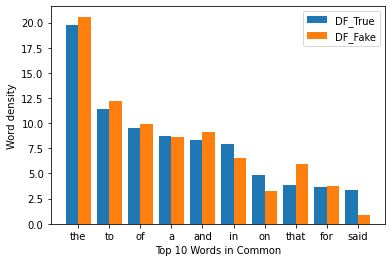

In [23]:
topwords = [triple[1] for triple in common[0:10]]
true_densities = [triple[0] for triple in common[0:10]]
fake_densities = [triple[2] for triple in common[0:10]]

x=np.arange(10)
plt.bar(x-.2,true_densities,width=.4,label='DF_True')
plt.bar(x+.2,fake_densities,width=.4,label='DF_Fake')
plt.xticks(ticks=x,labels=topwords)
plt.legend(loc='upper right')
plt.xlabel('Top 10 Words in Common')
plt.ylabel('Word density')
plt.show()

Let's check out the correlation in each of the two big columns above.

In [26]:
# PearsonR test for correlation
A=tuple(den[0] for den in common)
B=tuple(den[2] for den in common)
C=tuple(den[0] for den in common_dist)
D=tuple(den[2] for den in common_dist)

print(scipy.stats.pearsonr(A,B))
print(scipy.stats.pearsonr(C,D))
del A,B,C,D

PearsonRResult(statistic=0.971508119328221, pvalue=0.0)
PearsonRResult(statistic=0.8867362764160239, pvalue=0.0)


There is incredibly strong correlation between the two datasets (DF_True and DF_Fake) as far as word densities of common words goes, but again, this is not surprising since whether an article is real or fake, it is still the same language, so word densities are highly likely to be correlated.

This was still worth exploring though, since on the off-chance they weren't correlated, it could have rendered the classification problem trivial.

As previously mentioned though (and as can be seen above), some words appear quite frequently in one set and not the other (i.e. '(Reuters)' and '-').  Are there more of these we should consider stripping so as to not make classification potentially trivial?  To determine this, we can look at the word densities of the symmetric difference of Words_T and Words_F defined above.

We'll build two columns of triples of the form: (density, word, distinct density) -- one for the True-only words and one for the Fake-only words.

In [12]:
# Take symmetric difference (XOR) of the two sets
Words_sym = Words_T ^ Words_F

# create density datasets and sort by descending density
# link the word with the density again, but here we have to be careful since we don't know which 
# dictionary the word belongs to

sym_T=[]
sym_F=[]

for word in Words_sym:
    try:
        sym_T.append((d_True[word],word,d_T_distinct[word]))
    except KeyError:
        sym_F.append((d_Fake[word],word,d_F_distinct[word]))
        
# so, we try to look for word in True dictionaries, else in Fake dictionaries if lookup error

sym_T.sort(reverse=True)
sym_F.sort(reverse=True)

# again, note: here we sort by descending densities

print('Densities for words that ONLY appear in True articles or Fake articles, but not both:')
print('Word density     DF_True word:     distinct density:               Word density   DF_Fake word:     distinct density:')
for n in range(30):
    print(sym_T[n],'                ',sym_F[n])

Densities for words that ONLY appear in True articles or Fake articles, but not both:
Word density     DF_True word:     distinct density:               Word density   DF_Fake word:     distinct density:
(0.5407853574263436, 'Trump’s', 0.22407433347340897)                  (0.08249222775861334, 'Via:', 0.07968144457220731)
(0.18602045104356352, '“I', 0.12938320026147454)                  (0.05902644691452664, 'more:', 0.05740811720114135)
(0.1557174207405332, '“The', 0.12350002334594014)                  (0.04620757207955368, 'Getty', 0.04569652059111622)
(0.13377223700798432, '“We', 0.10547695755708082)                  (0.04373748988543929, 'AT:', 0.04254503641241855)
(0.12149227249381332, '...', 0.09847317551477798)                  (0.04292832502874665, '2017@realDonaldTrump', 0.0054086282526297855)
(0.09908016995844422, 'Obama’s', 0.06714292384554325)                  (0.04271538690856437, '21WIRE', 0.02874664622460713)
(0.08726712424709343, 'don’t', 0.06690946444413316)          

One word that stands out here is 'Trump's', which has a much higher density than any other word in either of the two columns.  What if we redo this assessment, but put distinct density first and order by distinct density?  For this, we just copy the previous cell and alter the ordering.

In [13]:
Words_sym = Words_T ^ Words_F

# create density datasets and sort by descending density
# link the word with the density again, but here we have to be careful since we don't know which 
# dictionary the word belongs to

sym_T=[]
sym_F=[]

for word in Words_sym:
    try:
        sym_T.append((d_T_distinct[word],word,d_True[word])) # <------- reordered here with distinct now first
    except KeyError:
        sym_F.append((d_F_distinct[word],word,d_Fake[word])) # <------- reordered here with distinct now first
        
# so, we try to look for word in True dictionaries, else in Fake dictionaries if lookup error

sym_T.sort(reverse=True)
sym_F.sort(reverse=True)

# again, note: here we sort by descending densities

print('Densities for words that ONLY appear in True articles or Fake articles, but not both:')
print('Distinct word density  DF_True word:   word density:               Distinct word density   DF_Fake word:     word density:')
for n in range(30):
    print(sym_T[n],'                ',sym_F[n])

Densities for words that ONLY appear in True articles or Fake articles, but not both:
Distinct word density  DF_True word:   word density:               Distinct word density   DF_Fake word:     word density:
(0.22407433347340897, 'Trump’s', 0.5407853574263436)                  (0.07968144457220731, 'Via:', 0.08249222775861334)
(0.12938320026147454, '“I', 0.18602045104356352)                  (0.05740811720114135, 'more:', 0.05902644691452664)
(0.12350002334594014, '“The', 0.1557174207405332)                  (0.04569652059111622, 'Getty', 0.04620757207955368)
(0.10547695755708082, '“We', 0.13377223700798432)                  (0.04254503641241855, 'AT:', 0.04373748988543929)
(0.09847317551477798, '...', 0.12149227249381332)                  (0.03402751160512755, 'Featured', 0.03407009922916401)
(0.06714292384554325, 'Obama’s', 0.09908016995844422)                  (0.02874664622460713, '21WIRE', 0.04271538690856437)
(0.06690946444413316, 'don’t', 0.08726712424709343)                  (

This gives even stronger evidence that we should remove 'Trump's', and maybe even '"I', '"The', and '"We'...down to some threshold.  'Trump's' appears at least once in a whopping 22% of True articles, and 0% of the Fake articles (somewhat surprisingly, since they are often political in nature).

Out of curiousity, how many such words were there from one group or the other?

In [39]:
print(len(sym_T))
print(len(sym_F))

103928
218978


So we can see there are more than twice as many words unique to Fake articles than those unique to True ones.  Of course this makes sense too, as we can already see some SPAM-like words in the right column above.

So we'll probably run algorithms on the text bodies with '(Reuters)', '-', 'Trump's', '"I', '"The', and '"We' filtered out of the data.